In [6]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
# os.environ['PYTHONPATH'] += ':/content/gdrive/MyDrive/22FL/CS101-TA/optimized_bio_sensor/RockleyCodesign'
os.environ['PYTHONPATH'] += ':/content/gdrive/MyDrive/optimized_bio_sensor/RockleyCodesign'
# %cd /content/gdrive/MyDrive/22FL/CS101-TA/optimized_bio_sensor/RockleyCodesign
%cd /content/gdrive/MyDrive/optimized_bio_sensor/rockley

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/.shortcut-targets-by-id/1EaHvULJYewcfEpQ7wlYgmG1eRbVcahUv/optimized_bio_sensor/rockley


In [7]:
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt

In [62]:
import utils.data as data_loader
 
train, val, test = data_loader.load_train_test_val(
    trainfile="../data/train_regression.parquet",
    testfile="../data/test_regression.parquet",
    standardize=True,
    precision=64,
)

Xtrain, Ytrain = train
Xval, Yval = val
Xtest, Ytest = test

def convert(Y):
  cY = np.array(Y)
  for i in range(len(Y)):
    if Y[i] < 60:
      cY[i] = 0
    elif 60 <= Y[i] < 100:
      cY[i] = 1
    elif 100 <= Y[i] < 160:
      cY[i] = 2
    else:
      cY[i] = 3
  return cY

Yclass_train = (Ytrain < 80).astype(int)
Yclass_val = (Yval < 80).astype(int)
Ymclass_train = convert(Ytrain)
Ymclass_val = convert(Yval)

In [63]:
from sklearn.linear_model import LogisticRegression
import sklearn.metrics

clf = LogisticRegression(C=2, max_iter=400)
clf.fit(Xtrain, Yclass_train)
predicted = clf.predict(Xval)
print("Accuracy:", np.mean(predicted == Yclass_val))

prob_predict = clf.predict_proba(Xval)
print("AUC:", sklearn.metrics.roc_auc_score(Yclass_val, prob_predict[:, 1]))

Accuracy: 0.94615625
AUC: 0.9899060594378744


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [64]:
Xtrain_sub = Xtrain[:10000]
Ytrain_sub = Ymclass_train[:10000]

In [65]:
from sklearn.linear_model import LogisticRegression
import sklearn.metrics

clf = LogisticRegression(C=100, max_iter=10000)
clf.fit(Xtrain_sub, Ytrain_sub)
predicted = clf.predict(Xval)
print("Accuracy:", np.mean(predicted == Ymclass_val))
print(predicted)

prob_predict = clf.predict_proba(Xval)
print("AUC OVR:", sklearn.metrics.roc_auc_score(Ymclass_val, prob_predict, multi_class='ovr'))

prob_predict = clf.predict_proba(Xval)
print("AUC OVO:", sklearn.metrics.roc_auc_score(Ymclass_val, prob_predict, multi_class='ovo'))

Accuracy: 0.90840625
[1. 0. 2. ... 0. 2. 0.]
AUC OVR: 0.9930954348388101
AUC OVO: 0.9930743666531616


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


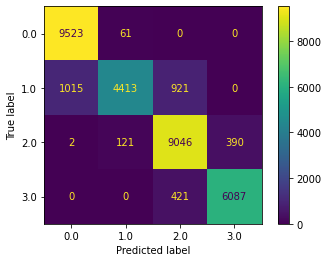

In [66]:
import sklearn.metrics

sklearn.metrics.plot_confusion_matrix(clf, Xval, Ymclass_val)

# Cut out

In [71]:
import utils.data as data_loader
 
train, val, test = data_loader.load_train_test_val(
    trainfile="../data/train_regression.parquet",
    testfile="../data/test_regression.parquet",
    standardize=True,
    precision=64,
)

Xtrain, Ytrain = train
Xval, Yval = val
Xtest, Ytest = test

def convert(Y):
  cY = np.array(Y)
  for i in range(len(Y)):
    if Y[i] < 60:
      cY[i] = 0
    elif 60 <= Y[i] < 100:
      cY[i] = 1
    elif 100 <= Y[i] < 160:
      cY[i] = 2
    else:
      cY[i] = 3
  return cY

Yclass_train = (Ytrain < 80).astype(int)
Yclass_val = (Yval < 80).astype(int)
Ymclass_train = convert(Ytrain)
Ymclass_val = convert(Yval)

In [74]:
Xtrain_sub = Xtrain[:10000]
Ytrain_sub = Yclass_train[:10000]

In [79]:
from sklearn.linear_model import LogisticRegression
import sklearn.metrics

clf = LogisticRegression(C=5, max_iter=1000)
clf.fit(Xtrain_sub, Ytrain_sub)
predicted = clf.predict(Xval)
print("Accuracy:", np.mean(predicted == Yclass_val))

prob_predict = clf.predict_proba(Xval)
print("AUC:", sklearn.metrics.roc_auc_score(Yclass_val, prob_predict[:, 1]))

Accuracy: 0.93115625
AUC: 0.9847243536308103


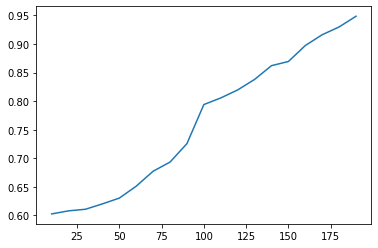

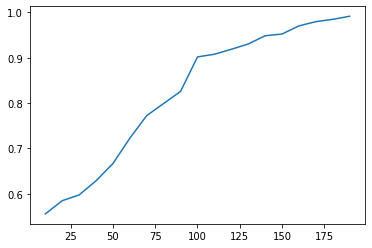

In [96]:
s = sorted([(clf.coef_[0][i], i) for i in range(197)], reverse=True)

acc = []
auc = []
kvals = range(10, 197, 10)
for k in kvals:
  idxs = [s[i][1] for i in range(k)]
  Xcut = Xtrain_sub[:, idxs]
  cut_clf = LogisticRegression(C=20, max_iter=2000)
  cut_clf.fit(Xcut, Ytrain_sub)
  predicted = cut_clf.predict(Xval[:, idxs])
  acc.append(np.mean(predicted == Yclass_val))

  prob_predict = cut_clf.predict_proba(Xval[:, idxs])
  auc.append(sklearn.metrics.roc_auc_score(Yclass_val, prob_predict[:, 1]))

plt.plot(kvals, acc)
plt.plot(kvals, auc)
plt.title("Performance vs. No. Lasers")
plt.xlabel("No. Lasers")
plt.ylabel("Score")
plt.show()

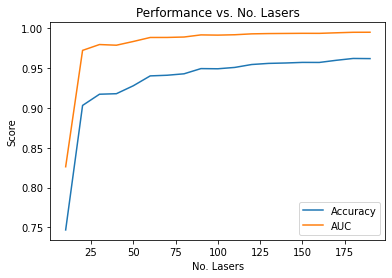

In [99]:
acc = []
auc = []
kvals = range(10, 197, 10)
for k in kvals:
  idxs = [int(i / k * 196) for i in range(1, k + 1)]
  # print(idxs)
  Xcut = Xtrain_sub[:, idxs]
  cut_clf = LogisticRegression(C=20, max_iter=2000)
  cut_clf.fit(Xcut, Ytrain_sub)
  predicted = cut_clf.predict(Xval[:, idxs])
  acc.append(np.mean(predicted == Yclass_val))

  prob_predict = cut_clf.predict_proba(Xval[:, idxs])
  auc.append(sklearn.metrics.roc_auc_score(Yclass_val, prob_predict[:, 1]))

plt.plot(kvals, acc)
plt.plot(kvals, auc)
plt.title("Performance vs. No. Lasers")
plt.xlabel("No. Lasers")
plt.ylabel("Score")
plt.legend(["Accuracy", "AUC"])
plt.show()

In [100]:
Xtrain_sub = Xtrain[:10000]
Ymtrain_sub = Ymclass_train[:10000]

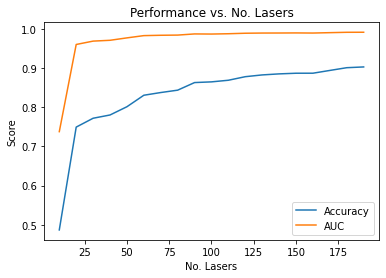

In [102]:
acc = []
auc = []
kvals = range(10, 197, 10)
for k in kvals:
  idxs = [int(i / k * 196) for i in range(1, k + 1)]
  # print(idxs)
  Xcut = Xtrain_sub[:, idxs]
  cut_clf = LogisticRegression(C=100, max_iter=10000)
  cut_clf.fit(Xcut, Ymtrain_sub)
  predicted = cut_clf.predict(Xval[:, idxs])
  acc.append(np.mean(predicted == Ymclass_val))

  prob_predict = cut_clf.predict_proba(Xval[:, idxs])
  auc.append(sklearn.metrics.roc_auc_score(Ymclass_val, prob_predict, multi_class='ovr'))

plt.plot(kvals, acc)
plt.plot(kvals, auc)
plt.title("Performance vs. No. Lasers")
plt.xlabel("No. Lasers")
plt.ylabel("Score")
plt.legend(["Accuracy", "AUC"])
plt.show()